In [27]:
import pandas as pd
from pairsbacktester import PairsBacktester
from utils import plot, get_regression_model, passes_adfuller_test

import statsmodels.api as sm

from data_processor import DataProcessor

In [2]:
# Loading the training data (2017 to 2022)
DATA = pd.read_csv('./data/closing_prices.csv').set_index('Date')

In [3]:
# Get the list of stock tickers
TICKERS = DATA.columns
TICKERS = ['ASIANPAINT', 'BAJFINANCE']

In [4]:
# Split training data (2017 to 2022) from the corpus

TRAINING_DATA = DATA[:'2023-01-01']
TESTING_DATA = DATA['2023-01-01':]


In [5]:
# Store all the cointegrated pairs in this list
COINT_PAIRS = []

for first_ticker in range(len(TICKERS) - 1):
    for second_ticker in range(first_ticker + 1, len(TICKERS)):

        ticker1 = TICKERS[first_ticker]
        ticker2 = TICKERS[second_ticker]

        data1 = TRAINING_DATA[ticker1]
        data2 = TRAINING_DATA[ticker2]

        # Retrieve model 
        model = get_regression_model(data1, data2)

        # Get residuals to test for stationarity
        residuals = model.resid

        # Gauge cointegration by performing the AdFuller test with a confidence level of 99%
        if passes_adfuller_test(residuals, alpha=0.01):
            # If test passes then add the pair to the list
            print (f'Pair ({ticker1}, {ticker2}) is cointegrated (99% confidence)')
            COINT_PAIRS.append({
                'pair': str((ticker1, ticker2)),
                'ticker1': ticker1,
                'ticker2': ticker2,
                'model': model
            })


Pair (ASIANPAINT, BAJFINANCE) is cointegrated (99% confidence)


In [13]:
TESTING_DATA

,ADANIENT,ADANIPORTS,APOLLOHOSP,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BEL,BPCL,...,SUNPHARMA,TCS,TATACONSUM,TATAMOTORS,TATASTEEL,TECHM,TITAN,TRENT,ULTRACEMCO,WIPRO
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,3841.199951,822.299988,4454.350098,3047.250000,941.599976,3573.949951,6553.750000,1552.500000,100.250000,166.925003,...,997.000000,3261.449951,762.299988,394.799988,119.250000,1009.500000,2565.750000,1342.150024,7017.950195,393.049988
2023-01-03,3830.949951,820.450012,4490.899902,3028.250000,962.299988,3601.699951,6606.250000,1563.000000,100.349998,168.425003,...,1009.099976,3311.350098,767.150024,393.899994,118.449997,1023.799988,2613.600098,1347.400024,6993.600098,397.049988
2023-01-04,3827.050049,810.000000,4433.299805,3016.850098,957.450012,3552.850098,6571.000000,1547.849976,98.750000,168.149994,...,1004.099976,3314.649902,762.250000,385.600006,115.750000,1020.299988,2597.550049,1307.400024,7005.350098,389.700012
2023-01-05,3829.800049,819.599976,4429.049805,3004.350098,949.549988,3621.149902,6100.049805,1468.849976,99.949997,171.175003,...,1016.200012,3311.100098,763.849976,386.899994,116.550003,1011.650024,2562.100098,1279.900024,7007.000000,386.899994
2023-01-06,3824.250000,806.099976,4387.450195,2978.399902,939.900024,3642.250000,5980.399902,1430.349976,98.949997,172.350006,...,1008.700012,3211.550049,761.349976,382.000000,115.650002,986.150024,2538.100098,1248.150024,6982.200195,382.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,2808.350098,1027.500000,5541.399902,3341.300049,1088.300049,6372.100098,7295.299805,1672.050049,174.800003,223.324997,...,1243.650024,3824.000000,992.799988,724.700012,133.550003,1275.150024,3627.350098,2965.500000,9969.000000,462.649994
2023-12-26,2865.449951,1028.750000,5633.149902,3383.350098,1094.250000,6464.549805,7162.299805,1645.300049,181.949997,225.800003,...,1247.500000,3795.550049,1007.349976,719.549988,135.199997,1282.000000,3656.699951,2970.000000,10018.650391,470.100006
2023-12-27,2843.350098,1024.400024,5687.450195,3404.449951,1106.349976,6709.649902,7232.799805,1669.449951,180.199997,227.350006,...,1252.449951,3811.199951,1026.750000,740.900024,137.199997,1280.150024,3689.250000,3010.750000,10436.099609,470.950012


In [17]:
model = COINT_PAIRS[0]['model']

In [ ]:
closing_prices = TESTING_DATA[['ASIANPAINT', 'BAJFINANCE']]
ticker1 = closing_prices['ASIANPAINT']
ticker2 = closing_prices['BAJFINANCE']

In [23]:
X_new = sm.add_constant(ticker1)
Y_preds = model.predict(X_new)
Y_actual = ticker2
test_residuals = Y_actual - Y_preds
test_residuals.name = 'Residuals'

In [24]:
pd.merge(
    left=closing_prices,
    left_index=True,
    right=test_residuals,
    right_index=True
)

,ASIANPAINT,BAJFINANCE,Residuals
Date,,,
2023-01-02,3047.250000,6553.750000,-29.556081
2023-01-03,3028.250000,6606.250000,70.077517
2023-01-04,3016.850098,6571.000000,63.107434
2023-01-05,3004.350098,6100.049805,-376.833815
2023-01-06,2978.399902,5980.399902,-432.108661
...,...,...,...
2023-12-22,3341.300049,7295.299805,-17.460847
2023-12-26,3383.350098,7162.299805,-254.775063
2023-12-27,3404.449951,7232.799805,-236.617800


In [29]:
data = DataProcessor.get_processed_data(
    pair_tickers=['ASIANPAINT', 'BAJFINANCE'],
    pair_closing_prices=closing_prices,
    pair_regression_model=model
)

In [30]:
data

,ASIANPAINT,BAJFINANCE,current_residual,previous_residual,residual_mean,residual_std,res_overval_cutoff,res_underval_cutoff,res_overval_stoploss,res_underval_stoploss
Date,,,,,,,,,,
2023-01-02,3047.250000,6553.750000,-29.556081,NaN,-7.906935e-12,495.124769,495.124769,-495.124769,990.249537,-990.249537
2023-01-03,3028.250000,6606.250000,70.077517,-29.556081,-7.906935e-12,495.124769,495.124769,-495.124769,990.249537,-990.249537
2023-01-04,3016.850098,6571.000000,63.107434,70.077517,-7.906935e-12,495.124769,495.124769,-495.124769,990.249537,-990.249537
2023-01-05,3004.350098,6100.049805,-376.833815,63.107434,-7.906935e-12,495.124769,495.124769,-495.124769,990.249537,-990.249537
2023-01-06,2978.399902,5980.399902,-432.108661,-376.833815,-7.906935e-12,495.124769,495.124769,-495.124769,990.249537,-990.249537
...,...,...,...,...,...,...,...,...,...,...
2023-12-22,3341.300049,7295.299805,-17.460847,149.524940,-7.906935e-12,495.124769,495.124769,-495.124769,990.249537,-990.249537
2023-12-26,3383.350098,7162.299805,-254.775063,-17.460847,-7.906935e-12,495.124769,495.124769,-495.124769,990.249537,-990.249537
2023-12-27,3404.449951,7232.799805,-236.617800,-254.775063,-7.906935e-12,495.124769,495.124769,-495.124769,990.249537,-990.249537


In [6]:
ALL_TRADES = pd.DataFrame()
PAIRWISE_BACKTESTING_INSTANCE = {}

# Iterate throught all coint pairs, backtest them, save their trades and backtesting instance (will need it later for plotting)
for pair in COINT_PAIRS:
    pair_bb = PairsBacktester(
        TESTING_DATA,
        pair['ticker1'],
        pair['ticker2'],
        pair['model']
    )
    pair_bb.trade()
    pair_bb.calculate_trade_statistics(equal_wts=True)
    PAIRWISE_BACKTESTING_INSTANCE[f'{str((pair["ticker1"], pair["ticker2"]))}'] = pair_bb
    ALL_TRADES = pd.concat([ALL_TRADES, pair_bb.trades])


In [7]:
# Analyze all the trades by pairs

results = ALL_TRADES.groupby('pair').agg(
    count_total_trades=('residual_state', 'count'),
    mean_trade_duration_days=('duration', 'mean'),
    mean_profit_perc_per_trade=('net_perc', 'mean') ,
    total_profit_perc=('net_perc', 'sum')
)

In [8]:
pair_bb.testing_data

,ASIANPAINT,BAJFINANCE,date,residual,prev_residual,signal
0,3047.250000,6553.750000,2023-01-02,-29.556081,NaN,none
1,3028.250000,6606.250000,2023-01-03,70.077517,-29.556081,none
2,3016.850098,6571.000000,2023-01-04,63.107434,70.077517,none
3,3004.350098,6100.049805,2023-01-05,-376.833815,63.107434,none
4,2978.399902,5980.399902,2023-01-06,-432.108661,-376.833815,none
...,...,...,...,...,...,...
240,3341.300049,7295.299805,2023-12-22,-17.460847,149.524940,exit overval: target
241,3383.350098,7162.299805,2023-12-26,-254.775063,-17.460847,none
242,3404.449951,7232.799805,2023-12-27,-236.617800,-254.775063,none
243,3397.250000,7258.649902,2023-12-28,-192.906671,-236.617800,none


In [9]:
ALL_TRADES

,pair,residual_state,entry_date,short_ticker,long_ticker,short_entry_price,long_entry_price,exit_date,short_exit_price,long_exit_price,exit_reason,short_net_perc,long_net_perc,duration,net_perc
0,"(ASIANPAINT, BAJFINANCE)",overval,2023-02-14,BAJFINANCE,ASIANPAINT,6458.700195,2777.000000,2023-03-08,5996.850098,2859.550049,target,0.071508,0.029726,22,0.050617
1,"(ASIANPAINT, BAJFINANCE)",overval,2023-07-04,BAJFINANCE,ASIANPAINT,7860.450195,3347.699951,2023-07-12,7431.950195,3406.750000,target,0.054513,0.017639,8,0.036076
2,"(ASIANPAINT, BAJFINANCE)",overval,2023-09-15,BAJFINANCE,ASIANPAINT,7492.200195,3196.649902,2023-10-03,7967.600098,3166.850098,stoploss,-0.063453,-0.009322,18,-0.036387
3,"(ASIANPAINT, BAJFINANCE)",overval,2023-11-16,BAJFINANCE,ASIANPAINT,7362.450195,3130.300049,2023-12-22,7295.299805,3341.300049,target,0.009121,0.067406,36,0.038263


In [10]:
results.sort_values(by='total_profit_perc', ascending=False)

,count_total_trades,mean_trade_duration_days,mean_profit_perc_per_trade,total_profit_perc
pair,,,,
"(ASIANPAINT, BAJFINANCE)",4,21.0,0.022142,0.088569


In [11]:
# Analyze a certain pair

pair_to_analyse = ('ASIANPAINT', 'BAJFINANCE')
backtesting_class = PAIRWISE_BACKTESTING_INSTANCE[str(pair_to_analyse)]

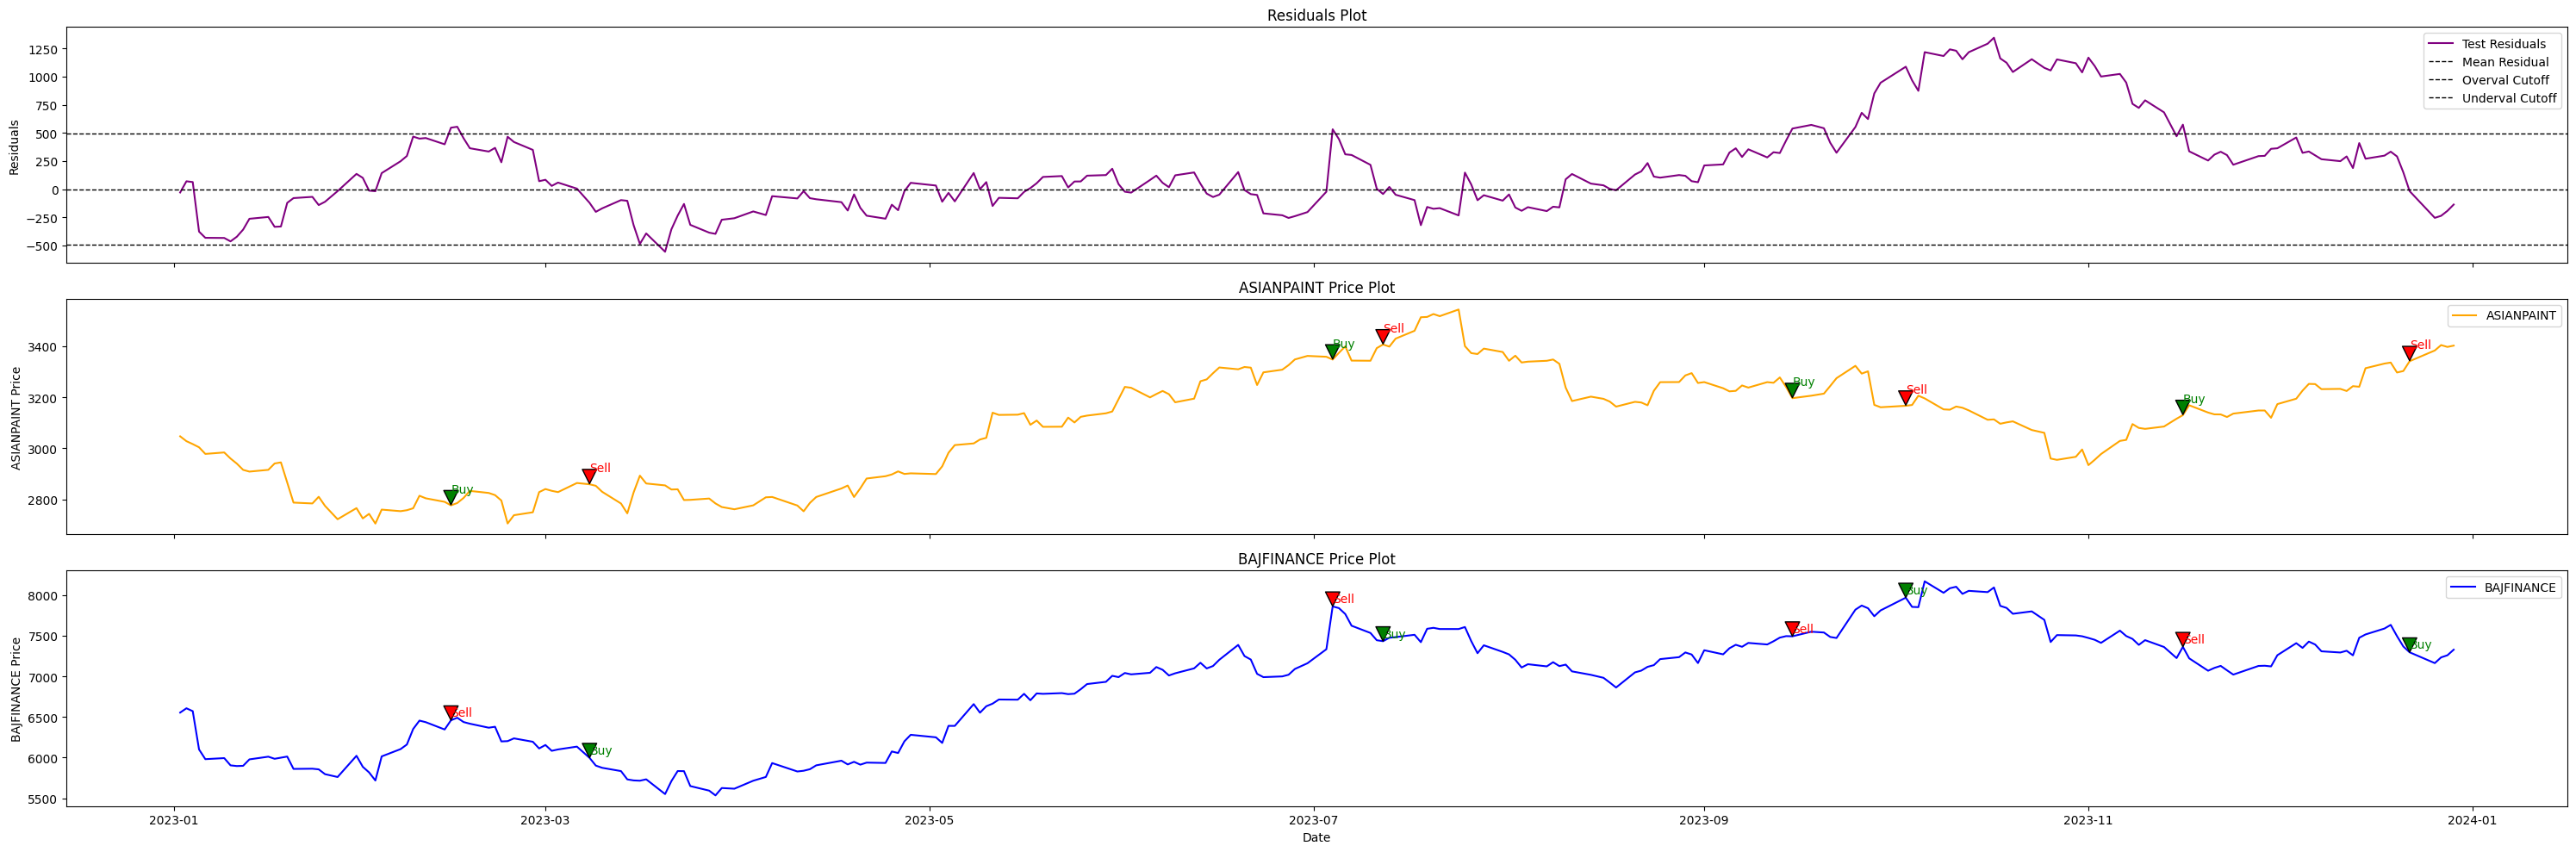

In [12]:
plot(
    t=backtesting_class.testing_data,
    ticker1=backtesting_class.ticker1,
    ticker2=backtesting_class.ticker2,
    res_mean=backtesting_class.residuals_mean,
    overval_cutoff=backtesting_class.res_overval_cutoff,
    underval_cutoff=backtesting_class.res_underval_cutoff
)